In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import sys
sys.path.insert(1, "../python/functions")
sys.path.insert(2, "../python/architecture")

In [3]:
from data_prep_functions import bike_prep
from model_functions import *
from plotting_functions import *
import no_gpu
import reproducible
from training_callback import BatchMSE

In [4]:
X_train, X_test, y_train, y_test = bike_prep()

In [5]:
# use samller dataset for increased speed
X_train = X_train[:1000]
X_test = X_test[:500]
y_train = y_train[:1000]
y_test = y_test[:500]

n_cols = X_train.shape[1]

In [6]:
particles = 10
early_stopping = False
early_stopping_diff = 1
batch_normal = False  # evtl. noch einbauen, obwohl im Paper nicht gemacht (aber Achtung mit den Dimensionen unten!!!)
shuffle = True
randomization = True

In [7]:
layers = 5
neurons = [64, 32, 32, 16, 1]
n_cols = X_train.shape[1]
batch_size = 50
epochs = 10

In [8]:
delta = 0.005
h_0 = 2
epsilon = 0.5

In [9]:
n = len(X_train)
num_batches = int(np.ceil(n / batch_size))
batch_indices = np.cumsum([0] + list(np.ones(num_batches) * batch_size))
batch_indices[-1] = n

In [10]:
model_dict = {}
weights_dict = {}
y_pred_dict = {}
jacobian_dict = {}
weights_vector_dict = {}
train_mse_dict = {}
test_mse_dict = {}
iteration_dict = {}

# init_model already has weights and biases following the Glorot distribution
# it can already be used to predict and evaluate, but it is very bad (<10% accuracy)
# only used to determine shapes and shape_elements via its weights
init_model = nn_model_structure(layers = layers,
                                neurons = neurons,
                                n_cols = n_cols,
                                classification = False)
init_model = nn_model_compile(init_model,
                              optimizer = "sgd")
weights = init_model.get_weights()
# shape contains the shapes of the weight matrices and bias vectors as a list of arrays
shapes = [np.array(params.shape) for params in weights]
# shape_elements contains the indices of the weights as a vector and tells where to cut
shape_elements = np.cumsum([0] + [np.prod(shape) for shape in shapes])

In [11]:
for i in range(particles):
    # just an initial model with the correct structure regarding neurons, layers, activation functions, Glorot initialization
    model = nn_model_structure(layers = layers,
                               neurons = neurons,
                               n_cols = n_cols,
                               classification = False)
    model = nn_model_compile(model,
                             optimizer = "sgd")
    # for every particle write the model in a dictionary
    model_dict["model_{}".format(str(i+1))] = model
    
    # for every particles write the weights and biases in a dictionary
    weights_dict["model_{}".format(str(i+1))] = model_dict["model_{}".format(str(i+1))]\
                                                    .get_weights()
    
    train_mse_dict["model_{}".format(str(i+1))] = []
    test_mse_dict["model_{}".format(str(i+1))] = []
    iteration_dict["model_{}".format(str(i+1))] = []

In [12]:
# mean_model as the model with the mean of the weights of all particle models
mean_weights = list(np.mean(list(weights_dict.values()), axis = 0))
mean_model = init_model
mean_model.set_weights(mean_weights)

mean_model_train_mse = np.array(mean_model.evaluate(X_train, y_train)[1])
mean_model_test_mse = np.array(mean_model.evaluate(X_test, y_test)[1])

16/16 [==============================] - 0s 993us/step - loss: 66458.5156 - mse: 66458.5156


In [13]:
for i in range(particles):
    print(model_dict["model_{}".format(str(i+1))].evaluate(X_test, y_test)[1])

16/16 [==============================] - 0s 686us/step - loss: 66411.4375 - mse: 66411.4375
66411.4375
16/16 [==============================] - 0s 686us/step - loss: 66964.4453 - mse: 66964.4453
66964.4453125
16/16 [==============================] - 0s 686us/step - loss: 66130.4609 - mse: 66130.4609
66130.4609375
16/16 [==============================] - 0s 714us/step - loss: 66675.1250 - mse: 66675.1250
66675.125
16/16 [==============================] - 0s 623us/step - loss: 66172.8672 - mse: 66172.8672
66172.8671875
16/16 [==============================] - 0s 685us/step - loss: 66539.5469 - mse: 66539.5469
66539.546875
16/16 [==============================] - 0s 686us/step - loss: 66067.4688 - mse: 66067.4688
66067.46875
16/16 [==============================] - 0s 747us/step - loss: 66869.8281 - mse: 66869.8281
66869.828125
16/16 [==============================] - 0s 686us/step - loss: 66435.5781 - mse: 66435.5781
66435.578125
16/16 [==============================] - 0s 686us/step - l

In [14]:
import time
start_time = time.time()

In [15]:
# loop over all epochs
for epoch in range(epochs):
    # shuffle the data
    if shuffle:
        indices = y_train.sample(frac=1).index
        X_batches = [np.array(X_train)[indices][int(batch_indices[i]):int(batch_indices[i+1])] for i in range(len(batch_indices)-1)]
        y_batches = [y_train.iloc[indices].reset_index(drop = True)[int(batch_indices[i]):int(batch_indices[i+1])] for i in range(len(batch_indices)-1)]
        y_batches = [np.array(i) for i in y_batches]
    # loop over all batches
    for b in range(num_batches):    
        for i in range(particles):
            # set new weights for model
            model_dict["model_{}".format(str(i+1))].set_weights(weights_dict["model_{}".format(str(i+1))])
            
            # for every particle write the predictions on the training batches in a dictionary
            y_pred_dict["model_{}".format(str(i+1))] = model_dict["model_{}".format(str(i+1))]\
                                                            .predict(X_batches[b])

            # for every particle write the Jacobian in a dictionary
            jacobian_dict["model_{}".format(str(i+1))] = 1/len(y_batches[b]) * (-2)*(y_batches[b] - y_pred_dict["model_{}".format(str(i+1))].ravel())
            
            # for every particle write the training accuracy of the current iteration in a dictionary
            train_mse_dict["model_{}".format(str(i+1))].append(model_dict["model_{}".format(str(i+1))]\
                                                                      .evaluate(X_train, y_train, verbose = 0)[1])
            
            # for every particle write the test accuracy of the current iteration in a dictionary
            test_mse_dict["model_{}".format(str(i+1))].append(model_dict["model_{}".format(str(i+1))]\
                                                                      .evaluate(X_test, y_test, verbose = 0)[1])
            
            # for every particle write the current iteration in a dictionary
            iteration_dict["model_{}".format(str(i+1))].append("Epoch: {}, Batch: {}.".format(epoch+1, b+1))
            
        # compute the mean of the predictions
        y_pred_mean = np.mean(list(y_pred_dict.values()), axis = 0)
        
        # compute the matrix D elementwise
        d = np.zeros(shape = (particles, particles))
        for k in range(particles):
            y_pred_centered = y_pred_dict["model_{}".format(str(k+1))] - y_pred_mean
            for j in range(particles):
                d[k][j] = np.dot(y_pred_centered.ravel(), jacobian_dict["model_{}".format(str(j+1))])
                                       
        # compute the scalar h_t
        h_t = h_0 / (np.sqrt(np.sum(d**2)) + epsilon)
        
        # Reshape the weights and biases so that they are no longer matrices and vectores, but now one single vector
        for i in range(particles):
            weights_array = np.array([])
            for j in range(len(weights_dict["model_{}".format(str(i+1))])):
                weights_array = np.append(weights_array, np.reshape(weights_dict["model_{}".format(str(i+1))][j], (1, -1)).ravel())
            weights_vector_dict["model_{}".format(str(i+1))] = weights_array
          
        # matrix with particle parameters as row vectors
        weights_all_ptcls = np.array(list(weights_vector_dict.values()))

        # compute the matrix with the updates for each particle
        weights_all_ptcls = weights_all_ptcls - h_t * np.matmul(d, weights_all_ptcls)

        for i in range(particles):
            # write the updates back into the dictionary
            weights_vector_dict["model_{}".format(str(i+1))] = weights_all_ptcls[i]
            # reshape the updates, so that they are of the original matrx and vector shape
            for l in range(len(shape_elements)-1):
                start = shape_elements[l]
                end = shape_elements[l+1]
                weights_dict["model_{}".format(str(i+1))][l] = np.reshape(weights_vector_dict["model_{}".format(str(i+1))][start:end], tuple(shapes[l]))
            
            if randomization:
                # add randomization/ noise to each particle
                new_weights = []
                # standard deviation for scaled Glorot distribution
                for s in range(len(shapes)):
                    if shapes[s].shape[0] == 2:
                        fan_in = shapes[s][0]
                        fan_out = shapes[s][1]
                    if shapes[s].shape[0] == 1:
                        fan_in = shapes[s-1][0]
                        fan_out = shapes[s][0]
                    stddev = np.sqrt(np.sqrt(h_t)) * np.sqrt(2 / (fan_in + fan_out))
                    noise = np.random.normal(loc = 0.0,
                                             scale = stddev,
                                             size = tuple(shapes[s]))
                    new_weights.append(weights_dict["model_{}".format(str(i+1))][s] + noise)
                weights_dict["model_{}".format(str(i+1))] = new_weights
    
    if randomization:
        # randomize particles around their mean
        weights_mean = list(np.mean(list(weights_dict.values()), axis = 0))
        for i in range(particles):
            new_weights = []
            # standard deviation for Glorot distribution
            for s in range(len(shapes)):
                if shapes[s].shape[0] == 2:
                    fan_in = shapes[s][0]
                    fan_out = shapes[s][1]
                if shapes[s].shape[0] == 1:
                    fan_in = shapes[s-1][0]
                    fan_out = shapes[s][0]
                stddev = np.sqrt(2 / (fan_in + fan_out))
                noise = np.random.normal(loc = 0.0,
                                         scale = stddev,
                                         size = tuple(shapes[s]))
                new_weights.append(weights_mean[s] + noise)
            weights_dict["model_{}".format(str(i+1))] = new_weights
            
    # update the mean_model
    mean_weights = list(np.mean(list(weights_dict.values()), axis = 0))
    mean_model.set_weights(mean_weights)
    
    mean_model_train_mse = np.append(mean_model_train_mse, np.array(mean_model.evaluate(X_train, y_train, verbose = 0)[1]))
    mean_model_test_mse = np.append(mean_model_test_mse, np.array(mean_model.evaluate(X_test, y_test, verbose = 0)[1]))
    
    # early stopping
    if early_stopping:
        if epoch == 0:
            test_mse_old = 0
        else:
            test_mse_new = mean_model_test_mse[epoch]
            if np.absolute(test_mse_new - test_mse_old) <= early_stopping_diff:
                print("STOP: Early Stopping after epoch {} because improvement in test accuracy is only {}."\
                                                                     .format(epoch+1, test_mse_new - test_mse_old))
                break
            test_mse_old = test_mse_new

In [16]:
end_time = time.time()
print("Calculation time: {}".format(end_time - start_time))

Calculation time: 261.28498935699463


In [17]:
for i in range(particles):
    print(model_dict["model_{}".format(str(i+1))].evaluate(X_test, y_test)[1])

16/16 [==============================] - 0s 697us/step - loss: 66361.5312 - mse: 66361.5312
66361.53125
16/16 [==============================] - 0s 1ms/step - loss: 66382.4844 - mse: 66382.4844
66382.484375
16/16 [==============================] - 0s 1ms/step - loss: 69112.1953 - mse: 69112.1953
69112.1953125
16/16 [==============================] - 0s 748us/step - loss: 67743.2734 - mse: 67743.2734
67743.2734375
16/16 [==============================] - 0s 797us/step - loss: 66627.7812 - mse: 66627.7812
66627.78125
16/16 [==============================] - 0s 818us/step - loss: 54550.1172 - mse: 54550.1172
54550.1171875
16/16 [==============================] - 0s 655us/step - loss: 18424034.0000 - mse: 18424034.0000
18424034.0
16/16 [==============================] - 0s 746us/step - loss: 67278.3516 - mse: 67278.3516
67278.3515625
16/16 [==============================] - 0s 763us/step - loss: 62234.5234 - mse: 62234.5234
62234.5234375
16/16 [==============================] - 0s 766us/st

In [18]:
model_dict["model_1"].get_weights()

[array([[-0.17911585, -0.0218001 , -0.03519537, ..., -0.18277653,
         -0.14128618,  0.04628758],
        [-0.16683167,  0.15661527,  0.03428955, ...,  0.02431276,
          0.12583642, -0.04064963],
        [-0.06626033,  0.09447122, -0.0881115 , ...,  0.03818865,
         -0.03773008, -0.14539099],
        ...,
        [-0.15591168,  0.11837351, -0.07668213, ..., -0.07402492,
         -0.04477006,  0.12625425],
        [ 0.0626938 ,  0.01590104,  0.06370228, ..., -0.14563654,
         -0.00054412, -0.02414042],
        [-0.00517633,  0.08818325,  0.0380142 , ..., -0.02683791,
         -0.19934095, -0.08049927]], dtype=float32),
 array([ 0.05162771, -0.33481026, -0.0069309 , -0.06585412,  0.10988159,
        -0.28492346, -0.07984031,  0.09487814,  0.17054433,  0.1314898 ,
         0.3890557 , -0.02523335, -0.0887069 ,  0.05659596, -0.00385168,
         0.13296033,  0.05044593, -0.27429816,  0.16096875,  0.02826216,
        -0.02419692, -0.01525457, -0.10080178,  0.22550805,  0.084

In [19]:
y_pred_dict["model_1"]

array([[-0.32795614],
       [-0.5567244 ],
       [-0.38466644],
       [-0.23648188],
       [-0.3487568 ],
       [-0.3098024 ],
       [-0.25159717],
       [-0.32237166],
       [-0.46562326],
       [-0.36013985],
       [-0.43127453],
       [-0.19429874],
       [-0.5956625 ],
       [-0.0811443 ],
       [-0.3686694 ],
       [-0.26707608],
       [-0.42565757],
       [-0.36014122],
       [-0.32630312],
       [-0.42335415],
       [-0.25725535],
       [-0.40786374],
       [-0.5848456 ],
       [-0.29917967],
       [-0.34738237],
       [-0.2960738 ],
       [-0.2653787 ],
       [-0.2909026 ],
       [-0.35414636],
       [-0.45874387],
       [-0.20687363],
       [-0.384692  ],
       [-0.5245388 ],
       [-0.41747308],
       [-0.5216802 ],
       [-0.4117934 ],
       [-0.3270507 ],
       [-0.21298349],
       [-0.26223034],
       [-0.39603078],
       [-0.25784764],
       [-0.28636196],
       [-0.3853271 ],
       [-0.34032208],
       [-0.46825922],
       [-0

In [20]:
jacobian_dict["model_1"]

array([-22.89311825,  -0.34226898,  -9.21538666, -10.60945928,
       -17.01395027,  -3.1723921 ,  -4.73006389, -10.81289487,
        -8.93862493,  -6.85440559, -17.85725098,  -0.20777195,
        -9.2238265 , -11.20324577,  -1.85474678, -26.85068304,
        -1.6970263 ,  -7.29440565,  -2.21305212, -11.77693417,
       -10.13029021,  -0.65631455,  -6.38339382, -15.89196719,
       -15.01389529, -28.13184295,  -3.61061515,  -7.0916361 ,
        -8.01416585,  -1.93834975,  -0.32827495, -10.17538768,
        -1.42098155, -12.25669892,  -2.10086721,  -1.85647174,
       -19.69308203,  -0.04851934,  -1.05048921,  -0.57584123,
        -8.05031391, -17.45145448,  -7.13541308,  -4.49361288,
       -12.85873037, -15.25227   ,  -1.50452394,  -0.21017721,
        -3.81315196,  -6.29795599])

In [21]:
print(mean_model_train_mse)
print(mean_model_test_mse)

[73307.421875  73359.953125  73327.6953125 73336.7265625 73396.671875
 73401.8828125 73350.2109375 73291.1015625 73381.234375  73357.4375
 73440.09375  ]
[66458.515625  66509.140625  66477.796875  66486.296875  66543.140625
 66547.7578125 66498.1328125 66441.7890625 66527.7578125 66506.203125
 66584.1015625]


In [22]:
train_mse_dict

{'model_1': [73259.7734375,
  73268.296875,
  73280.3984375,
  73141.84375,
  73371.109375,
  73156.6015625,
  73312.234375,
  73283.359375,
  73276.7578125,
  73170.828125,
  73299.34375,
  73161.21875,
  73126.3828125,
  73070.3828125,
  73089.8046875,
  73108.109375,
  73113.8046875,
  72668.53125,
  68560.828125,
  62632.8828125,
  73447.25,
  73323.7109375,
  73313.0390625,
  73269.4453125,
  71935.7578125,
  50910.95703125,
  61236.88671875,
  92601.484375,
  73125.703125,
  73530.328125,
  73065.59375,
  73333.4296875,
  73124.1875,
  73624.609375,
  73357.28125,
  73208.0,
  73620.3125,
  73120.4765625,
  73262.1328125,
  73321.53125,
  73430.9296875,
  73014.7265625,
  72650.4609375,
  73290.640625,
  73006.2578125,
  73524.7421875,
  73109.3515625,
  73654.6171875,
  73311.390625,
  73119.21875,
  73305.2890625,
  72793.4375,
  72958.828125,
  72900.40625,
  73206.390625,
  72854.015625,
  73233.296875,
  72831.75,
  73235.9296875,
  72789.171875,
  72635.6875,
  48443.390625

In [23]:
test_mse_dict

{'model_1': [66411.4375,
  66420.984375,
  66433.2265625,
  66298.9921875,
  66513.390625,
  66314.15625,
  66464.8046875,
  66435.4609375,
  66429.2421875,
  66327.1796875,
  66449.53125,
  66317.3203125,
  66282.1328125,
  66228.5625,
  66246.765625,
  66263.515625,
  66268.984375,
  65840.3359375,
  62001.26171875,
  56413.80859375,
  66570.84375,
  66472.1484375,
  66454.3203125,
  66406.2109375,
  65133.1796875,
  47132.48828125,
  55119.9375,
  88712.0859375,
  66284.2109375,
  66674.78125,
  66226.09375,
  66485.375,
  66283.015625,
  66766.859375,
  66508.640625,
  66365.4765625,
  66763.984375,
  66280.421875,
  66416.7578125,
  66472.9453125,
  66581.0,
  66176.1015625,
  65828.625,
  66440.6875,
  66168.609375,
  66660.5390625,
  66268.03125,
  66763.8984375,
  66465.3203125,
  66280.4296875,
  66459.5625,
  65969.34375,
  66125.7265625,
  66072.1171875,
  66365.1484375,
  66028.4453125,
  66391.1640625,
  66007.1796875,
  66392.953125,
  65965.765625,
  65813.890625,
  4428

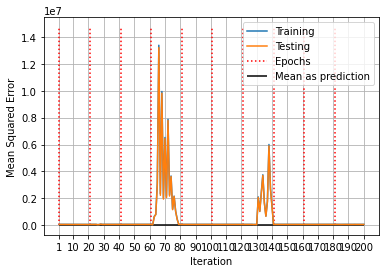

In [24]:
nn_plot_iter_mse(train_mse_dict["model_1"],
                 test_mse_dict["model_1"],
                 iteration_dict["model_1"],
                 mse_mean = mean_squared_error(y_test, np.ones(shape = (len(y_test),))*np.mean(y_test)))

## Jetzt mit der Jacobimatrix aus Tensorflow

In [25]:
model_dict = {}
weights_dict = {}
y_pred_dict = {}
jacobian_dict = {}
weights_vector_dict = {}
train_mse_dict = {}
test_mse_dict = {}
iteration_dict = {}

# init_model already has weights and biases following the Glorot distribution
# it can already be used to predict and evaluate, but it is very bad (<10% accuracy)
# only used to determine shapes and shape_elements via its weights
init_model = nn_model_structure(layers = layers,
                                neurons = neurons,
                                n_cols = n_cols,
                                classification = False)
init_model = nn_model_compile(init_model,
                              optimizer = "sgd")
weights = init_model.get_weights()
# shape contains the shapes of the weight matrices and bias vectors as a list of arrays
shapes = [np.array(params.shape) for params in weights]
# shape_elements contains the indices of the weights as a vector and tells where to cut
shape_elements = np.cumsum([0] + [np.prod(shape) for shape in shapes])

In [26]:
for i in range(particles):
    # just an initial model with the correct structure regarding neurons, layers, activation functions, Glorot initialization
    model = nn_model_structure(layers = layers,
                               neurons = neurons,
                               n_cols = n_cols,
                               classification = False)
    model = nn_model_compile(model,
                             optimizer = "sgd")
    # for every particle write the model in a dictionary
    model_dict["model_{}".format(str(i+1))] = model
    
    # for every particles write the weights and biases in a dictionary
    weights_dict["model_{}".format(str(i+1))] = model_dict["model_{}".format(str(i+1))]\
                                                    .get_weights()
    
    train_mse_dict["model_{}".format(str(i+1))] = []
    test_mse_dict["model_{}".format(str(i+1))] = []
    iteration_dict["model_{}".format(str(i+1))] = []

In [27]:
# mean_model as the model with the mean of the weights of all particle models
mean_weights = list(np.mean(list(weights_dict.values()), axis = 0))
mean_model = init_model
mean_model.set_weights(mean_weights)

mean_model_train_mse = np.array(mean_model.evaluate(X_train, y_train)[1])
mean_model_test_mse = np.array(mean_model.evaluate(X_test, y_test)[1])

16/16 [==============================] - 0s 811us/step - loss: 66306.4531 - mse: 66306.4531


In [28]:
import tensorflow as tf

loss_fct = tf.keras.losses.MeanSquaredError(reduction = "none")

In [29]:
# loop over all epochs
for epoch in range(epochs):
    # shuffle the data
    if shuffle:
        indices = y_train.sample(frac=1).index
        X_batches = [np.array(X_train)[indices][int(batch_indices[i]):int(batch_indices[i+1])] for i in range(len(batch_indices)-1)]
        y_batches = [y_train.iloc[indices].reset_index(drop = True)[int(batch_indices[i]):int(batch_indices[i+1])] for i in range(len(batch_indices)-1)]
        y_batches = [np.array(i) for i in y_batches]
    # loop over all batches
    for b in range(num_batches):    
        for i in range(particles):
            # set new weights for model
            model_dict["model_{}".format(str(i+1))].set_weights(weights_dict["model_{}".format(str(i+1))])
            
            # for every particle write the predictions on the training batches in a dictionary
            y_pred_dict["model_{}".format(str(i+1))] = model_dict["model_{}".format(str(i+1))]\
                                                            .predict(X_batches[b])

            # for every particle write the Jacobian in a dictionary
            y_batch_tf = tf.constant(y_batches[b])
            y_pred_tf = tf.Variable(y_pred_dict["model_{}".format(str(i+1))])
            
            with tf.GradientTape() as tape:
                loss_value = loss_fct(y_batch_tf, y_pred_tf)
            jacobian_tf = tape.gradient(loss_value, y_pred_tf)
            
            jacobian_dict["model_{}".format(str(i+1))] = jacobian_tf.numpy()
            
            # for every particle write the training accuracy of the current iteration in a dictionary
            train_mse_dict["model_{}".format(str(i+1))].append(model_dict["model_{}".format(str(i+1))]\
                                                                      .evaluate(X_train, y_train, verbose = 0)[1])
            
            # for every particle write the test accuracy of the current iteration in a dictionary
            test_mse_dict["model_{}".format(str(i+1))].append(model_dict["model_{}".format(str(i+1))]\
                                                                      .evaluate(X_test, y_test, verbose = 0)[1])
            
            # for every particle write the current iteration in a dictionary
            iteration_dict["model_{}".format(str(i+1))].append("Epoch: {}, Batch: {}.".format(epoch+1, b+1))
            
        # compute the mean of the predictions
        y_pred_mean = np.mean(list(y_pred_dict.values()), axis = 0)
        
        # compute the matrix D elementwise
        d = np.zeros(shape = (particles, particles))
        for k in range(particles):
            y_pred_centered = y_pred_dict["model_{}".format(str(k+1))] - y_pred_mean
            for j in range(particles):
                d[k][j] = np.dot(y_pred_centered.ravel(), jacobian_dict["model_{}".format(str(j+1))])
                                       
        # compute the scalar h_t
        h_t = h_0 / (np.sqrt(np.sum(d**2)) + epsilon)
        
        # Reshape the weights and biases so that they are no longer matrices and vectores, but now one single vector
        for i in range(particles):
            weights_array = np.array([])
            for j in range(len(weights_dict["model_{}".format(str(i+1))])):
                weights_array = np.append(weights_array, np.reshape(weights_dict["model_{}".format(str(i+1))][j], (1, -1)).ravel())
            weights_vector_dict["model_{}".format(str(i+1))] = weights_array
          
        # matrix with particle parameters as row vectors
        weights_all_ptcls = np.array(list(weights_vector_dict.values()))

        # compute the matrix with the updates for each particle
        weights_all_ptcls = weights_all_ptcls - h_t * np.matmul(d, weights_all_ptcls)

        for i in range(particles):
            # write the updates back into the dictionary
            weights_vector_dict["model_{}".format(str(i+1))] = weights_all_ptcls[i]
            # reshape the updates, so that they are of the original matrx and vector shape
            for l in range(len(shape_elements)-1):
                start = shape_elements[l]
                end = shape_elements[l+1]
                weights_dict["model_{}".format(str(i+1))][l] = np.reshape(weights_vector_dict["model_{}".format(str(i+1))][start:end], tuple(shapes[l]))
            if randomization:
                # add randomization/ noise to each particle
                new_weights = []
                # standard deviation for scaled Glorot distribution
                for s in range(len(shapes)):
                    if shapes[s].shape[0] == 2:
                        fan_in = shapes[s][0]
                        fan_out = shapes[s][1]
                    if shapes[s].shape[0] == 1:
                        fan_in = shapes[s-1][0]
                        fan_out = shapes[s][0]
                    stddev = np.sqrt(np.sqrt(h_t)) * np.sqrt(2 / (fan_in + fan_out))
                    noise = np.random.normal(loc = 0.0,
                                             scale = stddev,
                                             size = tuple(shapes[s]))
                    new_weights.append(weights_dict["model_{}".format(str(i+1))][s] + noise)
                weights_dict["model_{}".format(str(i+1))] = new_weights
    if randomization:
        # randomize particles around their mean
        weights_mean = list(np.mean(list(weights_dict.values()), axis = 0))
        for i in range(particles):
            new_weights = []
            # standard deviation for Glorot distribution
            for s in range(len(shapes)):
                if shapes[s].shape[0] == 2:
                    fan_in = shapes[s][0]
                    fan_out = shapes[s][1]
                if shapes[s].shape[0] == 1:
                    fan_in = shapes[s-1][0]
                    fan_out = shapes[s][0]
                stddev = np.sqrt(2 / (fan_in + fan_out))
                noise = np.random.normal(loc = 0.0,
                                         scale = stddev,
                                         size = tuple(shapes[s]))
                new_weights.append(weights_mean[s] + noise)
            weights_dict["model_{}".format(str(i+1))] = new_weights
    
    # update the mean_model
    mean_weights = list(np.mean(list(weights_dict.values()), axis = 0))
    mean_model.set_weights(mean_weights)
    
    mean_model_train_mse = np.append(mean_model_train_mse, np.array(mean_model.evaluate(X_train, y_train, verbose = 0)[1]))
    mean_model_test_mse = np.append(mean_model_test_mse, np.array(mean_model.evaluate(X_test, y_test, verbose = 0)[1]))
    
    # early stopping
    if early_stopping:
        if epoch == 0:
            test_mse_old = 0
        else:
            test_mse_new = mean_model_test_mse[epoch]
            if np.absolute(test_mse_new - test_mse_old) <= early_stopping_diff:
                print("STOP: Early Stopping after epoch {} because improvement in test accuracy is only {}."\
                                                                     .format(epoch+1, test_mse_new - test_mse_old))
                break
            test_mse_old = test_mse_new

In [30]:
print(mean_model_train_mse)
print(mean_model_test_mse)

[73149.515625  73191.921875  73137.046875  73172.4375    73186.09375
 73144.03125   73282.046875  73263.28125   73332.578125  73227.171875
 73099.3046875]
[66306.453125  66347.3046875 66294.703125  66328.84375   66340.515625
 66300.5703125 66436.234375  66418.9609375 66488.6171875 66380.75
 66265.765625 ]


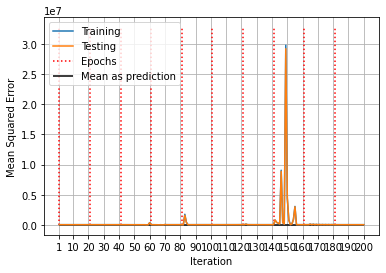

In [31]:
nn_plot_iter_mse(train_mse_dict["model_1"],
                 test_mse_dict["model_1"],
                 iteration_dict["model_1"],
                 mse_mean = mean_squared_error(y_test, np.ones(shape = (len(y_test),))*np.mean(y_test)))

## Jetzt mit dem ursprünglichen EnKF-Algorithmus wie für inverse Probleme

#### Problem: 
$C^{ww}$ ist singuläre Matrix und kann nicht invertiert werden. Mit der Pseudoinversen kommt der Error "SVD did not converge" und dieser Error für kleinere Gamma-Diagonalmatrizen später. Obwohl sich der MSE verringert, ist er dennoch mit $10^{23}$ viel zu groß, als dass das so Sinn ergeben würde.

#### scheinbar doch nicht immer...

In [32]:
model_dict = {}
weights_dict = {}
y_pred_dict = {}
jacobian_dict = {}
weights_vector_dict = {}
train_mse_dict = {}
test_mse_dict = {}
iteration_dict = {}

# init_model already has weights and biases following the Glorot distribution
# it can already be used to predict and evaluate, but it is very bad (<10% accuracy)
# only used to determine shapes and shape_elements via its weights
init_model = nn_model_structure(layers = layers,
                                neurons = neurons,
                                n_cols = n_cols,
                                classification = False)
init_model = nn_model_compile(init_model,
                              optimizer = "sgd")
weights = init_model.get_weights()
# shape contains the shapes of the weight matrices and bias vectors as a list of arrays
shapes = [np.array(params.shape) for params in weights]
# shape_elements contains the indices of the weights as a vector and tells where to cut
shape_elements = np.cumsum([0] + [np.prod(shape) for shape in shapes])

In [33]:
for i in range(particles):
    # just an initial model with the correct structure regarding neurons, layers, activation functions, Glorot initialization
    model = nn_model_structure(layers = layers,
                               neurons = neurons,
                               n_cols = n_cols,
                               classification = False)
    model = nn_model_compile(model,
                             optimizer = "sgd")
    # for every particle write the model in a dictionary
    model_dict["model_{}".format(str(i+1))] = model
    
    # for every particles write the weights and biases in a dictionary
    weights_dict["model_{}".format(str(i+1))] = model_dict["model_{}".format(str(i+1))]\
                                                    .get_weights()
    
    train_mse_dict["model_{}".format(str(i+1))] = []
    test_mse_dict["model_{}".format(str(i+1))] = []
    iteration_dict["model_{}".format(str(i+1))] = []

In [34]:
# loop over all epochs
for epoch in range(epochs):
    # shuffle the data
    if shuffle:
        indices = y_train.sample(frac=1).index
        X_batches = [np.array(X_train)[indices][int(batch_indices[i]):int(batch_indices[i+1])] for i in range(len(batch_indices)-1)]
        y_batches = [y_train.iloc[indices].reset_index(drop = True)[int(batch_indices[i]):int(batch_indices[i+1])] for i in range(len(batch_indices)-1)]
        y_batches = [np.array(i) for i in y_batches]
    # loop over all batches
    for b in range(num_batches):    
        for i in range(particles):
            # set new weights for model
            model_dict["model_{}".format(str(i+1))].set_weights(weights_dict["model_{}".format(str(i+1))])
            
            # for every particle write the predictions on the training batches in a dictionary
            y_pred_dict["model_{}".format(str(i+1))] = model_dict["model_{}".format(str(i+1))]\
                                                            .predict(X_batches[b])

            # for every particle write the training accuracy of the current iteration in a dictionary
            train_mse_dict["model_{}".format(str(i+1))].append(model_dict["model_{}".format(str(i+1))]\
                                                                      .evaluate(X_train, y_train, verbose = 0)[1])
            
            # for every particle write the test accuracy of the current iteration in a dictionary
            test_mse_dict["model_{}".format(str(i+1))].append(model_dict["model_{}".format(str(i+1))]\
                                                                      .evaluate(X_test, y_test, verbose = 0)[1])
            
            # for every particle write the current iteration in a dictionary
            iteration_dict["model_{}".format(str(i+1))].append("Epoch: {}, Batch: {}.".format(epoch+1, b+1))
            
        # compute the mean of the parameters
        weights_mean = np.mean(list(weights_dict.values()), axis = 0)
        mean_array = np.array([])
        for i in range(weights_mean.shape[0]):
            mean_array = np.append(mean_array, np.reshape(weights_mean[i], (1, -1)))
            
        # compute the mean of the predictions
        y_pred_mean = np.mean(list(y_pred_dict.values()), axis = 0)
                                       
        # Reshape the weights and biases so that they are no longer matrices and vectores, but now one single vector
        for i in range(particles):
            weights_array = np.array([])
            for j in range(len(weights_dict["model_{}".format(str(i+1))])):
                weights_array = np.append(weights_array, np.reshape(weights_dict["model_{}".format(str(i+1))][j], (1, -1)).ravel())
            weights_vector_dict["model_{}".format(str(i+1))] = weights_array
            
        # compute the matrices C
        weight_diff_dict = {}
        pred_diff_theta_dict = {}
        pred_diff_w_dict = {}
        c_theta_w_dict = {}
        c_w_w_dict = {}
        for i in range(particles):
            weight_diff_dict["model_{}".format(str(i+1))] = weights_vector_dict["model_{}".format(str(i+1))] - mean_array
            pred_diff_theta_dict["model_{}".format(str(i+1))] = y_pred_dict["model_{}".format(str(i+1))] - y_pred_mean
            pred_diff_w_dict["model_{}".format(str(i+1))] = y_pred_dict["model_{}".format(str(i+1))] - y_pred_mean
        for i in range(particles):
            weight_diff_dict["model_{}".format(str(i+1))] = np.transpose(np.tile(weight_diff_dict["model_{}".format(str(i+1))], (pred_diff_theta_dict["model_{}".format(str(i+1))].shape[0], 1)))
            pred_diff_theta_dict["model_{}".format(str(i+1))] = np.transpose(np.tile(pred_diff_theta_dict["model_{}".format(str(i+1))], (1, weight_diff_dict["model_{}".format(str(i+1))].shape[0])))
            pred_diff_w_dict["model_{}".format(str(i+1))] = np.transpose(np.tile(pred_diff_w_dict["model_{}".format(str(i+1))], (1, pred_diff_w_dict["model_{}".format(str(i+1))].shape[0])))
            c_theta_w_dict["model_{}".format(str(i+1))] = np.multiply(weight_diff_dict["model_{}".format(str(i+1))], pred_diff_theta_dict["model_{}".format(str(i+1))])
            c_w_w_dict["model_{}".format(str(i+1))] = np.multiply(pred_diff_w_dict["model_{}".format(str(i+1))], pred_diff_w_dict["model_{}".format(str(i+1))])
        c_theta_w = np.mean(list(c_theta_w_dict.values()), axis = 0)
        c_w_w = np.mean(list(c_w_w_dict.values()), axis = 0)
          
        # matrix with particle parameters as row vectors
        # weights_all_ptcls = np.array(list(weights_vector_dict.values()))
        for i in range(particles):
            #print(i)
        # compute the matrix with the updates for each particle
            weights_vector_dict["model_{}".format(str(i+1))] = weights_vector_dict["model_{}".format(str(i+1))] + np.dot(np.dot(c_theta_w, np.linalg.pinv(c_w_w + np.diag(np.ones(c_w_w.shape[0])*0.5))), y_batches[b] - y_pred_dict["model_{}".format(str(i+1))].ravel())
            
        for i in range(particles):
            # write the updates back into the dictionary
            # weights_vector_dict["model_{}".format(str(i+1))] = weights_all_ptcls[i]
            # reshape the updates, so that they are of the original matrx and vector shape
            for l in range(len(shape_elements)-1):
                start = shape_elements[l]
                end = shape_elements[l+1]
                weights_dict["model_{}".format(str(i+1))][l] = np.reshape(weights_vector_dict["model_{}".format(str(i+1))][start:end], tuple(shapes[l]))

In [35]:
train_mse_dict

{'model_1': [72785.7265625,
  1.0243973034519246e+20,
  8.675735201775826e+19,
  7.755658593997056e+19,
  7.370623695698736e+19,
  7.2945682773822145e+19,
  7.101699424316817e+19,
  6.93983547974075e+19,
  6.929252460421081e+19,
  6.929218595462945e+19,
  6.907678722870162e+19,
  6.9296381691001045e+19,
  6.761087434608555e+19,
  6.800080514976003e+19,
  6.825677585475279e+19,
  6.752103984804974e+19,
  6.762949567501356e+19,
  6.757538650878745e+19,
  6.632739683079658e+19,
  6.5951592552515764e+19,
  6.546077935796958e+19,
  6.552030691749737e+19,
  6.363721293502402e+19,
  6.3336034709943615e+19,
  6.335446692287165e+19,
  6.3192777140937425e+19,
  6.322422757153833e+19,
  5.760756153704461e+19,
  5.742749671678699e+19,
  5.69707419944228e+19,
  5.6949939234425274e+19,
  5.5987193659005075e+19,
  5.603682121583637e+19,
  5.510150625650593e+19,
  5.496334602340611e+19,
  5.4066588737838514e+19,
  5.32766863903047e+19,
  5.3004447311267365e+19,
  4.960136646432391e+19,
  4.95856390500

In [36]:
mean_weights = list(np.mean(list(weights_dict.values()), axis = 0))
init_model.set_weights(mean_weights)

In [37]:
init_model.evaluate(X_test, y_test)

16/16 [==============================] - 0s 811us/step - loss: 21503775626043064320.0000 - mse: 21503775626043064320.0000


[2.1503775626043064e+19, 2.1503775626043064e+19]